In [5]:
!pip install transformers torch pillow tqdm sentencepiece
import zipfile
import os
import torch
from transformers import Pix2StructForConditionalGeneration, Pix2StructProcessor
from PIL import Image
import os
import json
import re
from tqdm import tqdm
import warnings
import matplotlib.pyplot as plt



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [3]:
# Cell 3: Configuration and Setup

# --- Configuration ---

# *** IMPORTANT: PLEASE UPDATE THESE PATHS ***
IMAGE_DIR = "/home/g2/Downloads/png"
# --- DATASET FILE PATHS ---

# 1. Base files (as .json containing a LIST)
BASE_DATASET_FILES = {
    "human": "/home/g2/Downloads/test_human.json",
    "augmented": "/home/g2/Downloads/test_augmented.json" # Assuming this is the augmented equivalent
}

# 2. DePlot files (as .jsonl)
DEPLOT_DATA_FILES = {
    "human": "/home/g2/Downloads/deplot_human_output.jsonl",
    "augmented": "/home/g2/Downloads/deplot_augmented_output.jsonl"
}

# --- MODEL AND PROMPT ---

# Model to use
MODEL_ID = "google/pix2struct-base"

COT_PROMPT_WITH_DEPLOT = (
    "Let's think step by step to solve this problem.\n"
    "Here is the data from the chart, linearized into a table format:\n"
    "--- START OF CHART DATA ---\n"
    "{deplot_data}\n"
    "--- END OF CHART DATA ---\n\n"
    "Using this chart data AND the provided image, answer the following question.\n"
    "First, identify the relevant numbers from the provided chart data or the image. "
    "Second, perform the necessary calculations. "
    "Finally, state the final answer clearly.\n\n"
    "Question: {question}"
)

# --- Device Setup ---
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")



Using device: cuda


In [4]:
# Cell 4: Load Model and Processor

print(f"Loading processor: {MODEL_ID}...")
try:
    processor = Pix2StructProcessor.from_pretrained(MODEL_ID)
    print("Processor loaded successfully.")
except Exception as e:
    print(f"Error loading processor: {e}")
    processor = None

print(f"Loading model: {MODEL_ID}...")
try:
    model = Pix2StructForConditionalGeneration.from_pretrained(MODEL_ID).to(device)
    model.eval() # Set to evaluation mode
    print("Model loaded successfully and set to eval mode.")
except Exception as e:
    print(f"Error loading model: {e}")
    model = None



Loading processor: google/pix2struct-base...
Processor loaded successfully.
Loading model: google/pix2struct-base...
Model loaded successfully and set to eval mode.


In [2]:
# Cell 5: Helper Functions

def load_jsonl_file(json_file_path):
    """
    Loads a dataset from a JSONL (JSON Lines) file.
    Each line in the file is expected to be a valid JSON object.
    """
    data = []
    try:
        with open(json_file_path, 'r') as f:
            for i, line in enumerate(f):
                if line.strip(): # Avoid empty lines
                    try:
                        data.append(json.loads(line))
                    except json.JSONDecodeError as e:
                        print(f"Error decoding JSON on line {i+1} in {json_file_path}: {e}")
                        print(f"Problematic line: {line.strip()}")
    except FileNotFoundError:
        print(f"Error: Dataset file not found at {json_file_path}")
        return None
    except Exception as e:
        print(f"An unexpected error occurred while reading {json_file_path}: {e}")
        return None

    print(f"Successfully loaded {len(data)} items from {json_file_path} (JSONL)")
    return data

def load_json_list_file(json_file_path):
    """
    Loads a dataset from a standard JSON file that contains a single list of objects.
    """
    try:
        with open(json_file_path, 'r') as f:
            data = json.load(f) # This reads the entire file as one JSON object
            if not isinstance(data, list):
                print(f"Error: File {json_file_path} does not contain a JSON list.")
                return None
            print(f"Successfully loaded {len(data)} items from {json_file_path} (JSON List)")
            return data
    except FileNotFoundError:
        print(f"Error: Dataset file not found at {json_file_path}")
        return None
    except json.JSONDecodeError as e:
        print(f"Error decoding JSON in {json_file_path}: {e}")
        return None
    except Exception as e:
        print(f"An unexpected error occurred while reading {json_file_path}: {e}")
        return None

def merge_datasets(base_data, deplot_data):
    """
    *** 1-to-1 MERGE LOGIC ***
    Merges datasets on a 1-to-1 index basis (parallel merge).
    Assumes item[i] in base_data corresponds to item[i] in deplot_data.
    """

    if len(base_data) != len(deplot_data):
        print(f"CRITICAL ERROR: Cannot perform 1-to-1 merge.")
        print(f"Base data has {len(base_data)} items.")
        print(f"DePlot data has {len(deplot_data)} items.")
        print("The files must have the exact same number of items to be merged 1-to-1.")
        return [] # Return empty list to stop evaluation

    print(f"Performing 1-to-1 parallel merge on {len(base_data)} items...")

    merged_data = []
    mismatch_count = 0

    # Use zip to combine the two lists in parallel
    for base_item, deplot_item in zip(base_data, deplot_data):

        # Safety check: warn if imgname keys don't match, but merge anyway
        if base_item.get('imgname') != deplot_item.get('imgname'):
            mismatch_count += 1

        # Perform the merge
        merged_item = base_item.copy()
        merged_item['deplot_table'] = deplot_item.get('deplot_table')
        merged_data.append(merged_item)

    if mismatch_count > 0:
        print(f"Warning: Found {mismatch_count} items where 'imgname' did not match between files.")
        print("Proceeding with 1-to-1 merge based on file order, as requested.")

    print(f"Successfully merged {len(merged_data)} items.")
    return merged_data

def calculate_relaxed_accuracy(predicted: str, ground_truth: str) -> bool:
    """
    Performs a relaxed accuracy check.
    Normalizes strings and checks if one is a substring of the other.
    """
    # (Note: Removed 'self' from the function signature)
    pred_norm = re.sub(r"[^\w\s\.]", "", str(predicted)).lower().strip()
    gt_norm = re.sub(r"[^\w\s\.]", "", str(ground_truth)).lower().strip()

    if not pred_norm or not gt_norm:
        # If either normalized string is empty, it's not a match
        return False

    # Check if the normalized prediction is in the ground truth, or vice-versa
    return (pred_norm in gt_norm) or (gt_norm in pred_norm)

# --- The 'parse_answer' function has been removed as it's no longer needed ---



In [6]:
# Cell 6: Evaluation Function

def evaluate_model(model, processor, dataset, image_dir, dataset_name):
    """
    Evaluates the model, saving progress and resuming from a progress file.
    Uses the relaxed accuracy function.
    """

    # Define a progress file path based on the dataset name
    progress_file = f"evaluation_progress_{dataset_name}.jsonl"
    processed_results = []
    processed_imgnames = set()

    # --- 1. Load existing progress ---
    try:
        if os.path.exists(progress_file):
            print(f"Loading existing progress from {progress_file}...")
            with open(progress_file, 'r') as f:
                for line in f:
                    if line.strip():
                        result = json.loads(line)
                        processed_results.append(result)
                        processed_imgnames.add(result['imgname'])
            print(f"Loaded {len(processed_results)} existing results.")
    except Exception as e:
        print(f"Warning: Could not load progress file {progress_file}. Starting fresh. Error: {e}")
        processed_results = []
        processed_imgnames = set()

    total_items_in_dataset = len(dataset)
    print(f"Starting evaluation... {len(processed_imgnames)}/{total_items_in_dataset} items already processed.")

    # --- 2. Process remaining items and save progress ---
    try:
        # Open progress file in append mode to save new results
        with open(progress_file, 'a') as f_progress:
            # Using tqdm for a progress bar
            for item in tqdm(dataset, desc=f"Evaluating {dataset_name}"):
                try:
                    imgname = item['imgname']

                    # *** RESUME LOGIC ***
                    if imgname in processed_imgnames:
                        continue # Skip this item, it's already processed

                    # 1. Get item details
                    question = item['query']
                    ground_truth_str = str(item['label'])
                    deplot_data = item.get('deplot_table', 'No data provided')

                    image_path = os.path.join(image_dir, imgname)

                    # 2. Load image
                    try:
                        image = Image.open(image_path).convert("RGB")
                    except FileNotFoundError:
                        print(f"Warning: Image file not found {image_path}. Skipping item {imgname}.")
                        continue # Skip this item, can't process without image

                    # 3. Format the CoT prompt
                    prompt_text = COT_PROMPT_WITH_DEPLOT.format(
                        deplot_data=deplot_data,
                        question=question
                    )

                    # 4. Process inputs and generate output
                    inputs = processor(images=image, text=prompt_text, return_tensors="pt").to(device)
                    generated_ids = model.generate(**inputs, max_new_tokens=512)
                    model_output = processor.decode(generated_ids[0], skip_special_tokens=True)

                    # 5. NEW RELAXED ACCURACY CHECK
                    is_correct = calculate_relaxed_accuracy(model_output, ground_truth_str)

                    # *** SAVE PROGRESS ***
                    result_to_save = {
                        'imgname': imgname,
                        'question': question,
                        'ground_truth': ground_truth_str,
                        'model_output': model_output,
                        'is_correct': is_correct
                    }
                    # Write to file immediately
                    f_progress.write(json.dumps(result_to_save) + '\n')

                    # Add to our in-memory list as well
                    processed_results.append(result_to_save)
                    processed_imgnames.add(imgname) # Ensure we don't process it again in this run

                except Exception as e:
                    print(f"Error processing item {item.get('imgname', 'N/A')}: {e}")
                    # Continue to the next item

    except KeyboardInterrupt:
        print("\nEvaluation interrupted. Progress saved. Re-run to resume.")
        return 0.0 # Return 0 for now, final accuracy isn't calculated

    # --- 3. Calculate final accuracy from all results ---
    if not processed_results:
        print("No items were successfully evaluated.")
        return 0.0

    total_predictions = len(processed_results)
    correct_predictions = sum(1 for res in processed_results if res['is_correct'])

    accuracy = (correct_predictions / total_predictions) * 100
    print(f"Evaluation complete (from progress file): {correct_predictions} / {total_predictions} correct ({accuracy:.2f}%)")

    # Optional: Check if all items from the dataset were processed
    if total_predictions < total_items_in_dataset:
        print(f"Warning: Processed {total_predictions} items, but dataset has {total_items_in_dataset} items.")

    return accuracy



In [7]:
# Cell 7: Run Evaluation

results = {}

if model and processor:
    # Use the file paths from Cell 3
    for dataset_name in BASE_DATASET_FILES.keys():
        print(f"\n--- Processing dataset: {dataset_name} ---")

        # 1. Load base data (using the JSON LIST function)
        base_file_path = BASE_DATASET_FILES[dataset_name]
        base_data = load_json_list_file(base_file_path)

        # 2. Load DePlot data (using the JSONL function)
        deplot_file_path = DEPLOT_DATA_FILES[dataset_name]
        deplot_data = load_jsonl_file(deplot_file_path)

        if base_data and deplot_data:
            # 3. Merge the datasets (using the 1-to-1 merge function)
            print(f"Merging '{dataset_name}' datasets...")
            merged_dataset = merge_datasets(base_data, deplot_data)

            if merged_dataset:
                # 4. Run evaluation on the merged data
                # *** Pass dataset_name for progress tracking ***
                accuracy = evaluate_model(model, processor, merged_dataset, IMAGE_DIR, dataset_name)
                results[dataset_name] = accuracy
            else:
                print(f"Skipping evaluation for {dataset_name}: Merged dataset is empty or merge failed.")
        else:
            print(f"Skipping evaluation for {dataset_name} due to loading errors.")
else:
    print("Model or processor not loaded. Skipping evaluation.")

print("\n--- Evaluation Complete ---")
for dataset_name, accuracy in results.items():
    print(f"Final Accuracy for {dataset_name}: {accuracy:.2f}%")




--- Processing dataset: human ---
Successfully loaded 1250 items from /home/g2/Downloads/test_human.json (JSON List)
Successfully loaded 1250 items from /home/g2/Downloads/deplot_human_output.jsonl (JSONL)
Merging 'human' datasets...
Performing 1-to-1 parallel merge on 1250 items...
Successfully merged 1250 items.
Loading existing progress from evaluation_progress_human.jsonl...
Loaded 300 existing results.
Starting evaluation... 300/1250 items already processed.


Evaluating human:   0%|          | 0/1250 [00:00<?, ?it/s]

Evaluating human: 100%|██████████| 1250/1250 [1:19:58<00:00,  3.84s/it]


Evaluation complete (from progress file): 515 / 625 correct (82.40%)

--- Processing dataset: augmented ---
Successfully loaded 1250 items from /home/g2/Downloads/test_augmented.json (JSON List)
Successfully loaded 1250 items from /home/g2/Downloads/deplot_augmented_output.jsonl (JSONL)
Merging 'augmented' datasets...
Performing 1-to-1 parallel merge on 1250 items...
Successfully merged 1250 items.
Starting evaluation... 0/1250 items already processed.


Evaluating augmented: 100%|██████████| 1250/1250 [4:31:13<00:00, 13.02s/it]  

Evaluation complete (from progress file): 901 / 987 correct (91.29%)

--- Evaluation Complete ---
Final Accuracy for human: 82.40%
Final Accuracy for augmented: 91.29%


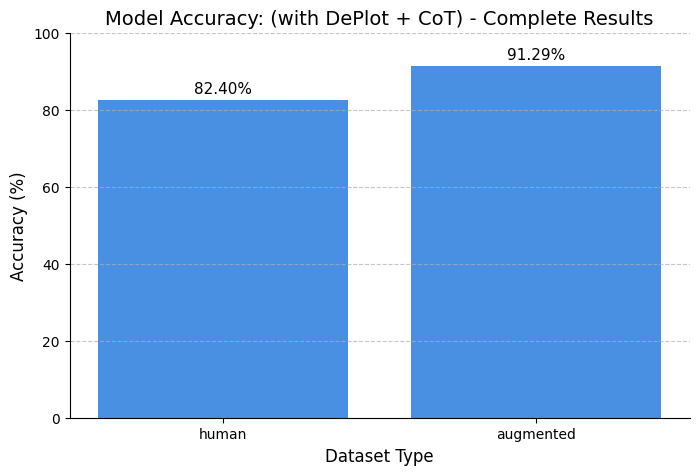

In [8]:
# Cell 8: Plot Results

# Use the 'results' dictionary generated in the previous cell
# No need to load from progress file again

if results:
    names = list(results.keys())
    values = list(results.values())

    plt.figure(figsize=(8, 5))
    # Define colors for different datasets if needed, e.g., {'human': '#4A90E2', 'augmented': '#FF6B6B'}
    colors = ['#4A90E2' for _ in names] # Default to blue for all if no specific colors defined

    bars = plt.bar(names, values, color=colors)

    plt.xlabel("Dataset Type", fontsize=12)
    plt.ylabel("Accuracy (%)", fontsize=12)
    # Update title to reflect that it might be complete or partial based on the previous cell's run
    plt.title(f"Model Accuracy: (with DePlot + CoT) - {'Complete' if all(name in results for name in BASE_DATASET_FILES.keys()) else 'Partial'} Results", fontsize=14)
    plt.ylim(0, 100)

    # Add accuracy numbers on top of bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval + 1, f'{yval:.2f}%', ha='center', va='bottom', fontsize=11)

    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.show()
else:
    print("No results available to plot.")